✅ 数据加载完成，共 1091 条记录
✅ 提取放电数据 374 条
✅ 额定容量: 1.1385 Ah, SOC范围: 0.000 ~ 1.000
✅ Voc范围: 2.802 ~ 4.178 V

📊 多项式拟合完成 (阶数: 4)
   R² = 0.947834, RMSE = 44.23 mV
   验证: SOC=50%时，拟合Voc = 3.7326 V

📝 Voc-SOC拟合多项式 (注意：公式中SOC为百分比0-100):
Voc(SOC%) = -6.521389e-08*SOC^4 + 1.567231e-05*SOC^3 + -1.248045e-03*SOC^2 + 4.201364e-02*SOC^1 + 3.200531e+00

📈 拟合质量: R²=0.9478, RMSE=44.23mV

💡 使用示例:
   get_voc_from_soc(0.5)  # 输入0.5(即50%)，返回Voc=3.7326V


C:\Users\30606\AppData\Local\Temp\ipykernel_45536\3799070937.py:227: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
c:\Users\30606\miniconda3\envs\oskay\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


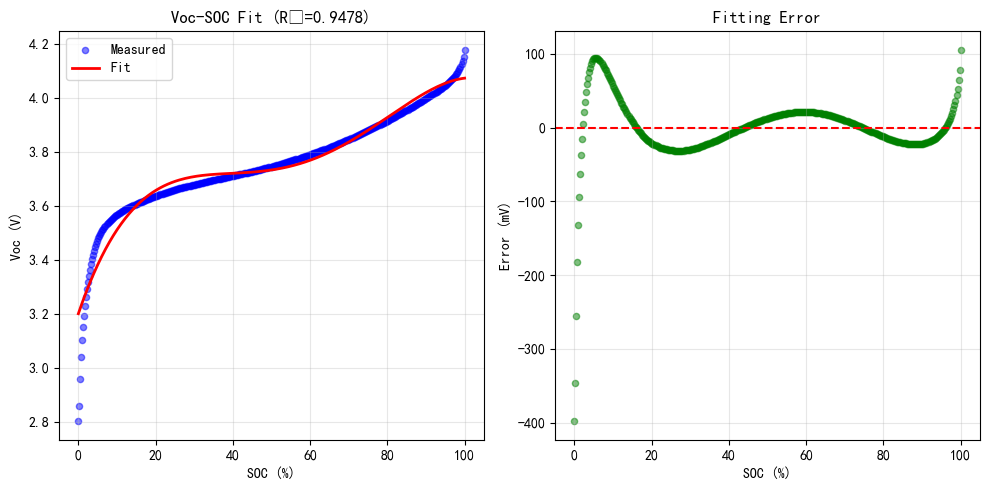


🔧 测试:
   SOC = 90% → Voc = 4.0190 V
   SOC = 50% → Voc = 3.7326 V
   SOC = 20% → Voc = 3.6565 V
   Voc = 3.4V → SOC = 5.6%


In [ ]:
"""
Voc-SOC关系计算方法（修复版）
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


class VocSocCalculator:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.discharge_data = None
        self.coeffs = None
        self.rated_capacity = None
        self.fit_metrics = {'RMSE': None, 'MAE': None, 'R2': None}
        # 记录拟合所用的SOC范围（验证用）
        self._soc_range = None  

    def load_data(self, sheet_name='Channel_1-008'):
        try:
            self.data = pd.read_excel(self.file_path, sheet_name=sheet_name)
            print(f"✅ 数据加载完成，共 {len(self.data)} 条记录")
            return self.data
        except Exception as e:
            raise Exception(f"数据加载失败：{str(e)}")

    def extract_discharge_data(self, step_index=7, min_current=0.1):
        """提取放电数据（降低电流阈值以捕获更多数据）"""
        if self.data is None:
            raise ValueError("请先加载数据")
        
        discharge = self.data[self.data['Step_Index'] == step_index].copy()
        # 放电时电流为负，取绝对值大于阈值
        self.discharge_data = discharge[abs(discharge['Current(A)']) > min_current].copy()
        self.discharge_data = self.discharge_data.dropna(
            subset=['Voltage(V)', 'Current(A)', 'Discharge_Capacity(Ah)']
        )
        
        if len(self.discharge_data) == 0:
            raise ValueError("未找到符合条件的放电数据，请检查step_index")
        
        print(f"✅ 提取放电数据 {len(self.discharge_data)} 条")
        return self.discharge_data

    def calculate_soc(self):
        """计算SOC（0-1范围）"""
        if self.discharge_data is None:
            raise ValueError("请先提取放电数据")

        max_cap = self.discharge_data['Discharge_Capacity(Ah)'].max()
        self.rated_capacity = max_cap
        
        if max_cap <= 0:
            raise ValueError("额定容量异常，请检查数据")

        # SOC = 1 - Q_discharge/Q_max
        self.discharge_data['SOC'] = 1 - (self.discharge_data['Discharge_Capacity(Ah)'] / max_cap)
        self.discharge_data['SOC'] = np.clip(self.discharge_data['SOC'], 0.0, 1.0)
        
        print(f"✅ 额定容量: {max_cap:.4f} Ah, SOC范围: {self.discharge_data['SOC'].min():.3f} ~ {self.discharge_data['SOC'].max():.3f}")
        return self.discharge_data['SOC']

    def estimate_voc(self):
        """估算Voc = V - I*R0（注意：放电时I为负，所以是V + |I|*R）"""
        if self.discharge_data is None:
            raise ValueError("请先提取数据")

        if 'Internal_Resistance(Ohm)' not in self.discharge_data.columns:
            raise KeyError("缺少Internal_Resistance(Ohm)列")

        I = self.discharge_data['Current(A)'].values
        V = self.discharge_data['Voltage(V)'].values
        R = self.discharge_data['Internal_Resistance(Ohm)'].values
        
        # Voc = V - I*R（当I为负时，相当于V + |I|*R）
        Voc = V - I * R
        
        # 合理性检查：锂电池Voc通常在2.5-4.5V之间
        if np.any(Voc > 4.5) or np.any(Voc < 2.0):
            print("⚠️ 警告: 估算的Voc超出正常范围(2.0-4.5V)，请检查电流方向或内阻单位")
            print(f"   Voc范围: {Voc.min():.3f} ~ {Voc.max():.3f} V")
        
        self.discharge_data['Voc_estimated'] = Voc
        print(f"✅ Voc范围: {Voc.min():.3f} ~ {Voc.max():.3f} V")
        return Voc

    def fit_voc_soc_polynomial(self, degree=3):  # 默认改为3次，避免过拟合
        """
        拟合Voc-SOC关系
        注意：使用SOC百分比(0-100)进行拟合以改善数值稳定性
        """
        if 'SOC' not in self.discharge_data.columns:
            raise ValueError("请先计算SOC")

        soc_pct = self.discharge_data['SOC'].values * 100  # 转为百分比0-100
        voc = self.discharge_data['Voc_estimated'].values
        
        # 按SOC排序，确保数据单调（避免时间序列乱序影响）
        sort_idx = np.argsort(soc_pct)
        soc_pct = soc_pct[sort_idx]
        voc = voc[sort_idx]
        
        # 记录拟合范围
        self._soc_range = (soc_pct.min(), soc_pct.max())
        
        # 多项式拟合
        self.coeffs = np.polyfit(soc_pct, voc, degree)
        poly_func = np.poly1d(self.coeffs)
        voc_pred = poly_func(soc_pct)
        
        # 计算指标
        error = voc - voc_pred
        self.fit_metrics['RMSE'] = np.sqrt(np.mean(error**2))
        self.fit_metrics['MAE'] = np.mean(np.abs(error))
        ss_res = np.sum(error**2)
        ss_tot = np.sum((voc - np.mean(voc))**2)
        self.fit_metrics['R2'] = 1 - (ss_res/ss_tot) if ss_tot > 0 else 0
        
        print(f"\n📊 多项式拟合完成 (阶数: {degree})")
        print(f"   R² = {self.fit_metrics['R2']:.6f}, RMSE = {self.fit_metrics['RMSE']*1000:.2f} mV")
        
        # 关键：打印验证信息，防止单位混淆
        test_val = poly_func(50)  # SOC=50%时的预测值
        print(f"   验证: SOC=50%时，拟合Voc = {test_val:.4f} V")
        
        return self.coeffs

    def get_voc_from_soc(self, soc):
        """
        根据SOC计算Voc（输入必须是0-1的小数！）
        
        参数:
            soc: 荷电状态，范围[0, 1]，如0.5表示50%
        """
        if self.coeffs is None:
            raise ValueError("请先进行多项式拟合")
        
        if not (0 <= soc <= 1):
            raise ValueError(f"SOC必须在[0,1]范围内，输入值为{soc}。若要输入百分比(50)，请改为0.5")
        
        # 内部转为0-100进行计算
        soc_pct = soc * 100
        poly_func = np.poly1d(self.coeffs)
        voc = poly_func(soc_pct)
        
        # 限制在合理范围内（防止外推异常）
        return float(np.clip(voc, 2.0, 4.5))

    def get_soc_from_voc(self, voc, tol=1e-6):
        """根据Voc反查SOC（二分法）"""
        if self.coeffs is None:
            raise ValueError("请先进行拟合")
        
        poly_func = np.poly1d(self.coeffs)
        
        # 在0-100%范围内二分查找
        low, high = 0, 100
        for i in range(100):  # 最多100次迭代
            mid = (low + high) / 2
            voc_mid = poly_func(mid)
            
            if abs(voc_mid - voc) < tol:
                return mid / 100
            
            if voc_mid > voc:
                high = mid
            else:
                low = mid
        
        return mid / 100

    def print_polynomial(self):
        """打印拟合公式（明确标注SOC单位）"""
        if self.coeffs is None:
            return
        
        print("\n📝 Voc-SOC拟合多项式 (注意：公式中SOC为百分比0-100):")
        terms = []
        for i, coef in enumerate(self.coeffs):
            power = len(self.coeffs) - 1 - i
            if abs(coef) > 1e-10:
                if power == 0:
                    terms.append(f"{coef:.6e}")
                else:
                    terms.append(f"{coef:.6e}*SOC^{power}")
        
        print("Voc(SOC%) = " + " + ".join(terms))
        print(f"\n📈 拟合质量: R²={self.fit_metrics['R2']:.4f}, RMSE={self.fit_metrics['RMSE']*1000:.2f}mV")
        
        # 提供使用示例
        print("\n💡 使用示例:")
        print(f"   get_voc_from_soc(0.5)  # 输入0.5(即50%)，返回Voc={self.get_voc_from_soc(0.5):.4f}V")

    def plot_fit(self):
        """绘制拟合结果"""
        if self.coeffs is None:
            return
        
        soc_pct = self.discharge_data['SOC'].values * 100
        voc = self.discharge_data['Voc_estimated'].values
        
        soc_fit = np.linspace(0, 100, 200)
        poly_func = np.poly1d(self.coeffs)
        voc_fit = poly_func(soc_fit)
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(soc_pct, voc, c='blue', s=20, alpha=0.5, label='Measured')
        plt.plot(soc_fit, voc_fit, 'r-', lw=2, label='Fit')
        plt.xlabel('SOC (%)')
        plt.ylabel('Voc (V)')
        plt.title(f'Voc-SOC Fit (R²={self.fit_metrics["R2"]:.4f})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        voc_pred = poly_func(soc_pct)
        plt.scatter(soc_pct, (voc - voc_pred)*1000, c='green', s=20, alpha=0.5)
        plt.axhline(0, color='r', linestyle='--')
        plt.xlabel('SOC (%)')
        plt.ylabel('Error (mV)')
        plt.title('Fitting Error')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


def main():
    # 修改为你的实际路径
    file_path = r"C:\Users\30606\Desktop\2026美赛\A题数据\CALCE\CS2_35\CS2_35_8_17_10.xlsx"
    
    calc = VocSocCalculator(file_path)
    
    try:
        # 标准流程
        calc.load_data()
        calc.extract_discharge_data(step_index=7)
        calc.calculate_soc()
        calc.estimate_voc()
        
        # 拟合（建议先用3阶，若R²太低再提高到4-5阶）
        calc.fit_voc_soc_polynomial(degree=4)
        calc.print_polynomial()
        calc.plot_fit()
        
        # 测试（注意：输入必须是0-1范围！）
        print("\n🔧 测试:")
        for soc_test in [0.9, 0.5, 0.2]:
            voc = calc.get_voc_from_soc(soc_test)
            print(f"   SOC = {soc_test*100:.0f}% → Voc = {voc:.4f} V")
        
        # 反查测试
        voc_test = 3.4
        soc = calc.get_soc_from_voc(voc_test)
        print(f"   Voc = {voc_test}V → SOC = {soc*100:.1f}%")
        
    except Exception as e:
        print(f"\n❌ 错误：{e}")


if __name__ == '__main__':
    main()

C:\Users\30606\AppData\Local\Temp\ipykernel_14924\3677089723.py:179: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\30606\AppData\Local\Temp\ipykernel_14924\3677089723.py:179: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\30606\AppData\Local\Temp\ipykernel_14924\3677089723.py:179: UserWarning: Glyph 21151 (\N{CJK UNIFIED IDEOGRAPH-529F}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\30606\AppData\Local\Temp\ipykernel_14924\3677089723.py:179: UserWarning: Glyph 32791 (\N{CJK UNIFIED IDEOGRAPH-8017}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\30606\AppData\Local\Temp\ipykernel_14924\3677089723.py:179: UserWarning: Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\30606\AppData\Local\Temp\ipykernel_14924\3677089723.py:179: U

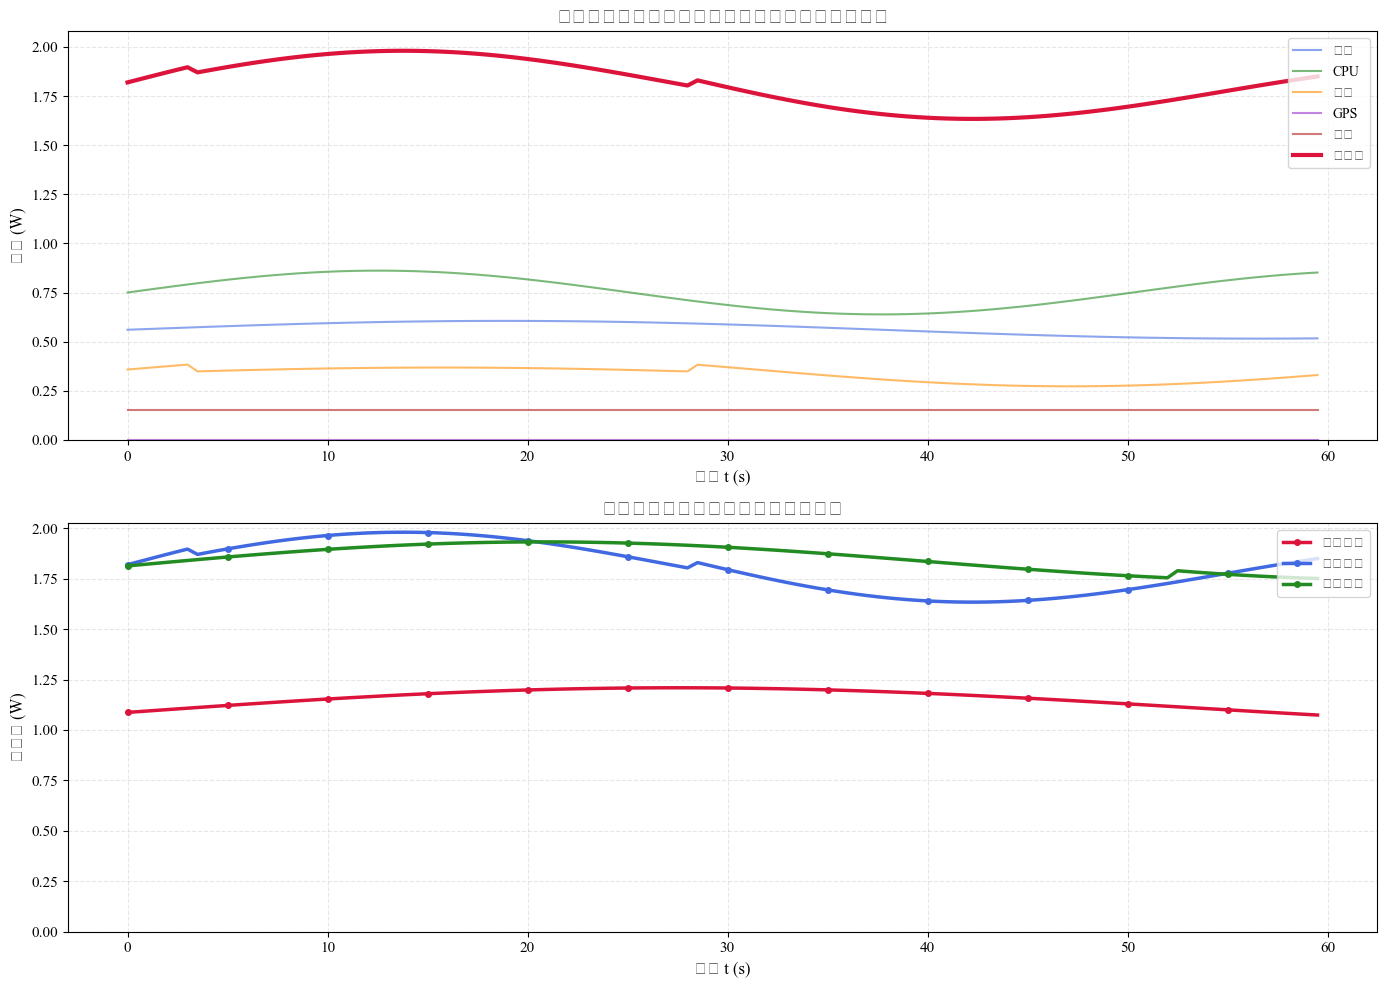

=== 各场景总功耗统计（0~60秒）===

【语音通话】
  总平均功耗 = 1.1601 W，峰值功耗 = 1.2092 W
  模块分解：屏幕=0.3201W, CPU=0.4532W, 网络=0.2368W, GPS=0.0000W, 后台=0.1500W

【网页浏览】
  总平均功耗 = 1.8103 W，峰值功耗 = 1.9802 W
  模块分解：屏幕=0.5674W, CPU=0.7596W, 网络=0.3333W, GPS=0.0000W, 后台=0.1500W

【视频播放】
  总平均功耗 = 1.8559 W，峰值功耗 = 1.9322 W
  模块分解：屏幕=0.6447W, CPU=0.6870W, 网络=0.3742W, GPS=0.0000W, 后台=0.1500W


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# ==================== 1. 文档中定义的各模块功耗公式（单位：W，mW→W÷1000） ====================
def p_screen(B):
    """屏幕功耗：P=451B+200（mW），B∈[0,1]（文档4.3.1）"""
    return (451 * B + 200) / 1000

def p_cpu(u, f):
    """CPU功耗：分段函数（mW），f为频率（MHz），u为利用率（0≤u≤1）（文档4.3.2）"""
    freq_coeffs = {598: (411, 261), 747: (484, 264), 1040: (545, 267), 1196: (742, 268), 1400: (825, 278)}
    freq_list = sorted(freq_coeffs.keys())
    
    # 频率插值逻辑
    if f in freq_coeffs:
        a, b = freq_coeffs[f]
    elif f < freq_list[0]:
        a, b = freq_coeffs[freq_list[0]]
    elif f > freq_list[-1]:
        a, b = freq_coeffs[freq_list[-1]]
    else:
        for i in range(len(freq_list)-1):
            f_left, f_right = freq_list[i], freq_list[i+1]
            if f_left < f < f_right:
                a_left, b_left = freq_coeffs[f_left]
                a_right, b_right = freq_coeffs[f_right]
                a = a_left + (a_right - a_left) * (f - f_left)/(f_right - f_left)
                b = b_left + (b_right - b_left) * (f - f_left)/(f_right - f_left)
                break
    return (a * u + b) / 1000

def p_network(S):
    """网络功耗：分段函数（mW），S为传输速率（KB/s）（文档4.3.3）"""
    if S < 400:
        return (159.5 + 0.568 * S) / 1000
    else:
        return (269.5 + 0.198 * S) / 1000

def p_gps(state):
    """GPS功耗：三状态（mW）（文档4.3.4）"""
    state_power = {"关闭": 0, "开启但未定位": 49.2, "正在定位": 444.9}
    return state_power[state] / 1000

def p_background(state):
    """后台功耗：三状态（mW）（文档4.3.5）"""
    state_power = {"休眠": 50, "轻度": 150, "重度": 500}
    return state_power[state] / 1000

# ==================== 2. 场景化动态参数生成（随时间t变化） ====================
def get_scenario_params(t, scenario):
    """根据时间t和场景，生成各模块的动态参数（对齐文档5节互斥组理念）"""
    
    if scenario == "talk_time":
        # 通话场景：屏幕低亮度或关闭(0.1~0.3，听筒模式)、CPU中等负载(0.2~0.4)、1040MHz
        # 网络中低传输(50~150KB/s，VoLTE语音数据)、GPS关闭、后台轻度
        return {
            "B": 0.2 + 0.1 * np.sin(t/20),           # 屏幕微亮或间歇亮屏
            "u": 0.3 + 0.1 * np.sin(t/15),           # CPU中等负载处理语音编解码
            "f": 1040,                               # 中等频率
            "S": 100 + 50 * np.sin(t/25),            # VoLTE通话数据传输，相对稳定
            "gps_state": "关闭",
            "bg_state": "轻度"
        }
    
    elif scenario == "web_browsing":
        # 网页浏览：屏幕高亮度(0.7~0.9，用户盯着屏幕)、CPU中高负载(0.5~0.8)、1196MHz
        # 网络中高传输(200~500KB/s，加载页面资源)、GPS关闭、后台轻度
        return {
            "B": 0.8 + 0.1 * np.sin(t/12),           # 屏幕高亮度保持可视性
            "u": 0.65 + 0.15 * np.sin(t/8),          # CPU负载波动较大（渲染页面、执行JS）
            "f": 1196,                               # 中高频率应对突发计算
            "S": 350 + 150 * np.sin(t/10),           # 网络传输波动（加载图片、脚本等）
            "gps_state": "关闭",
            "bg_state": "轻度"
        }
    
    elif scenario == "video_playback":
        # 视频播放：屏幕高亮度(0.85~1.0)、CPU中等负载(0.4~0.7)、1196MHz
        # 网络高传输(250~600KB/s，流媒体缓冲)、GPS关闭、后台轻度
        return {
            "B": 0.95 + 0.05 * np.sin(t/25),         # 屏幕接近最高亮度
            "u": 0.55 + 0.1 * np.sin(t/12),          # CPU中等负载（视频解码）
            "f": 1196,                               # 稳定频率处理视频流
            "S": 450 + 150 * np.sin(t/15),           # 高网络传输（高清视频流）
            "gps_state": "关闭",
            "bg_state": "轻度"
        }
    
    else:
        raise ValueError(f"无效场景！可选：talk_time/web_browsing/video_playback")

# ==================== 3. 计算总功耗与各模块功耗时间序列 ====================
def calculate_power_time_series(scenario, t_range):
    """计算指定场景下，随时间变化的总功耗与各模块功耗"""
    # 初始化数组
    p_screen_list = []
    p_cpu_list = []
    p_network_list = []
    p_gps_list = []
    p_bg_list = []
    p_total_list = []
    
    for t in t_range:
        params = get_scenario_params(t, scenario)
        # 计算各模块功耗
        ps = p_screen(params["B"])
        pc = p_cpu(params["u"], params["f"])
        pn = p_network(params["S"])
        pg = p_gps(params["gps_state"])
        pb = p_background(params["bg_state"])
        # 总功耗（文档公式：P_total = 各模块之和）
        pt = ps + pc + pn + pg + pb
        # 存入列表
        p_screen_list.append(ps)
        p_cpu_list.append(pc)
        p_network_list.append(pn)
        p_gps_list.append(pg)
        p_bg_list.append(pb)
        p_total_list.append(pt)
    
    return np.array(p_total_list), np.array([p_screen_list, p_cpu_list, p_network_list, p_gps_list, p_bg_list])

# ==================== 4. 绘制总功耗图表（双视图：分解图+对比图） ====================
def plot_total_power():
    # 时间范围：0~60秒，步长0.5秒（足够展示动态变化）
    t_range = np.arange(0, 60, 0.5)
    # 场景列表（已更新为三个新场景）
    scenarios = ["talk_time", "web_browsing", "video_playback"]
    # 场景名称中文映射
    scenario_cn = {
        "talk_time": "语音通话", 
        "web_browsing": "网页浏览", 
        "video_playback": "视频播放"
    }
    # 颜色配置（学术报告常用配色）
    colors = ["#DC143C", "#4169E1", "#228B22"]  # 红、蓝、绿
    module_colors = ["#4169E1", "#228B22", "#FF8C00", "#9932CC", "#B22222"]  # 屏幕、CPU、网络、GPS、后台
    
    # 创建画布（2个子图：上为单场景分解，下为多场景对比）
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # ---------------------- 子图1：单一场景（网页浏览）总功耗分解 ----------------------
    target_scenario = "web_browsing"
    p_total, modules_power = calculate_power_time_series(target_scenario, t_range)
    module_names = ["屏幕", "CPU", "网络", "GPS", "后台"]
    
    # 绘制各模块功耗（半透明）
    for i, (module_power, color) in enumerate(zip(modules_power, module_colors)):
        ax1.plot(t_range, module_power, color=color, linewidth=1.5, alpha=0.6, label=module_names[i])
    # 绘制总功耗（加粗突出）
    ax1.plot(t_range, p_total, color="#DC143C", linewidth=3, label="总功耗", zorder=5)
    
    # 子图1样式配置
    ax1.set_title(f"{scenario_cn[target_scenario]}场景总功耗与模块分解（文档公式计算）", fontsize=14, fontweight="bold")
    ax1.set_xlabel("时间 t (s)", fontsize=12)
    ax1.set_ylabel("功耗 (W)", fontsize=12)
    ax1.legend(loc="upper right", fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle="--")
    ax1.set_ylim(bottom=0)  # 功耗不小于0
    
    # ---------------------- 子图2：多场景总功耗对比 ----------------------
    for i, scenario in enumerate(scenarios):
        p_total, _ = calculate_power_time_series(scenario, t_range)
        # 绘制多场景总功耗，添加数据点标记（每5秒一个点）
        ax2.plot(t_range, p_total, color=colors[i], linewidth=2.5, label=scenario_cn[scenario],
                 marker='o', markersize=4, markevery=10)  # 每10个数据点（5秒）标记一次
    
    # 子图2样式配置
    ax2.set_title("多场景总功耗对比（文档公式计算）", fontsize=14, fontweight="bold")
    ax2.set_xlabel("时间 t (s)", fontsize=12)
    ax2.set_ylabel("总功耗 (W)", fontsize=12)
    ax2.legend(loc="upper right", fontsize=10)
    ax2.grid(True, alpha=0.3, linestyle="--")
    ax2.set_ylim(bottom=0)
    
    # 调整子图间距
    plt.tight_layout()
    # 保存图片（高分辨率，适合插入报告）
    plt.savefig("total_power_analysis.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # 输出关键统计信息
    print("=== 各场景总功耗统计（0~60秒）===")
    for scenario in scenarios:
        p_total, modules_power = calculate_power_time_series(scenario, t_range)
        ps, pc, pn, pg, pb = modules_power.mean(axis=1)
        print(f"\n【{scenario_cn[scenario]}】")
        print(f"  总平均功耗 = {np.mean(p_total):.4f} W，峰值功耗 = {np.max(p_total):.4f} W")
        print(f"  模块分解：屏幕={ps:.4f}W, CPU={pc:.4f}W, 网络={pn:.4f}W, GPS={pg:.4f}W, 后台={pb:.4f}W")

# ==================== 5. 执行绘图 ====================
if __name__ == "__main__":
    plot_total_power()

第一问建立的整体模型

电池Thevenin模型仿真（Python版本）
参数: R0=0.0211 Ω, Rp=0.0222 Ω, Cp=4715.0 F, Q_max=2.1386 Ah
初始条件: SOC=0.9000, Vp=0.0000 V
时间范围: 0~36000 s
求解中...
✓ 求解完成，共计 22163 个时间点
✓ 求解被事件终止：SOC在 t=22151.74s 达到0

仿真结果统计
初始SOC: 0.9000
最终SOC: -0.0000
SOC变化: -0.9000 (90.00%)
平均电流: 0.4462 A
电流范围: [0.2862, 0.5719] A
端电压范围: [3.1819, 4.0116] V
功率范围: [1.1463, 2.1917] W

✓ 图形已保存为 battery_thevenin_results.png


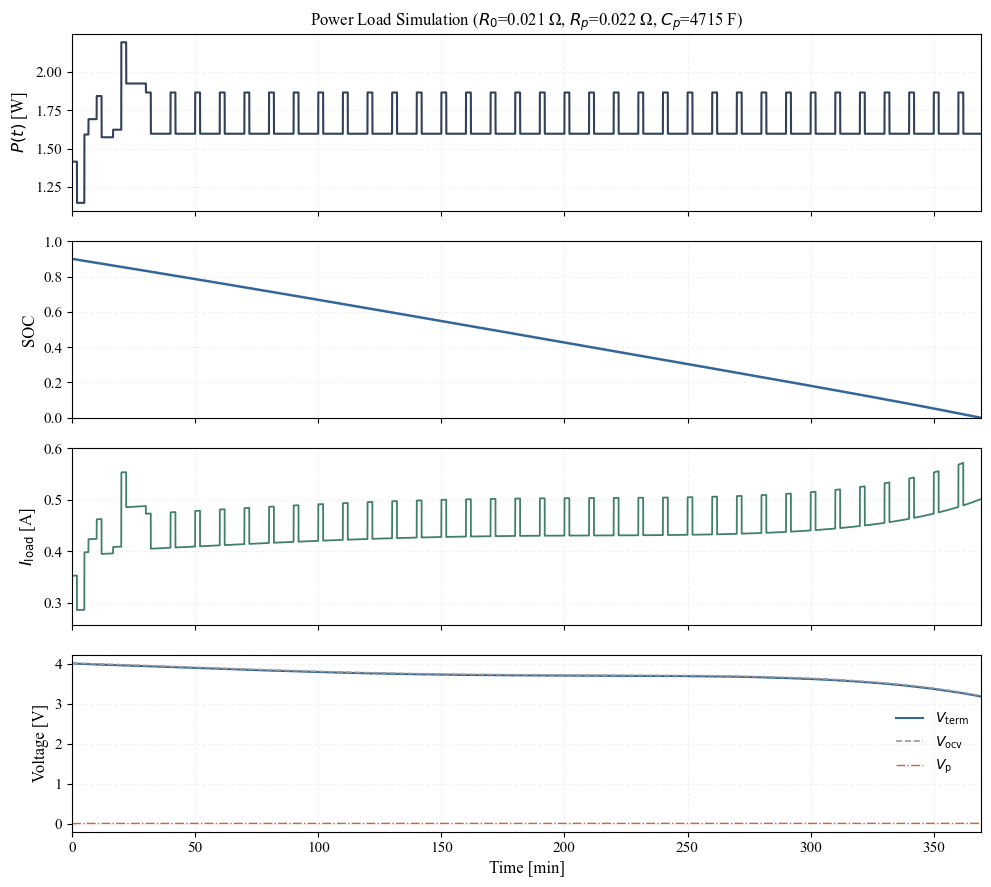

✓ 数据已导出到 battery_simulation_results.csv

仿真完成！


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
电池一阶Thevenin模型 + 时变功率负载求解程序
求解方法：消元降阶为ODE + scipy.integrate.solve_ivp (DOP853高精度积分器)
状态变量：x = [SOC(t); Vp(t)]
输出：SOC(t)轨迹及电压电流响应
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# ==================== 可修改参数区 ====================
# 1. 电路模型参数（根据您的电池数据修改）
R0   = 0.0210830         # 欧姆内阻 [Ohm]
Rp   = 0.02218          # 极化电阻 [Ohm]  
Cp   = 4715             # 极化电容 [Farad]
Q_max = 2.1386 * 3600   # 电池容量 [Ampere-second]，例如 1.1386Ah = 4099.0 As

# 2. OCV与SOC的函数关系（替换为实际拟合公式或查表）
# 输入：soc (标量或数组，范围[0,1])
# 输出：开路电压 Vocv [Volt]
# 示例：5次多项式拟合
def Vocv_func(soc):
    """开路电压与SOC关系（用户指定的4次多项式）
    Voc(soc) = -6.521389e-08*SOC^4 + 1.567231e-05*SOC^3 -1.248045e-03*SOC^2 + 4.201364e-02*SOC + 3.200531e+0
    输入soc范围为[0,1]
    """
    coeffs = np.array([-6.521389e+0, 1.567231e+1, -1.248045e+1, 4.201364e+0, 3.200531e+0])
    return np.polyval(coeffs, soc)

# ==================== 组件功耗函数（Python格式，单位：W） ====================
# 说明：数字编码替代字符串状态，便于向量化操作

def p_screen(B):
    """屏幕功耗：B∈[0,1]，P=451B+200 (mW)"""
    return (451 * B + 200) / 1000

def p_cpu(u, f):
    """CPU功耗：含频率线性插值
    u∈[0,1]利用率，f∈[598,1400]MHz频率"""
    freq_points = np.array([598, 747, 1040, 1196, 1400])
    a_coeffs = np.array([411, 484, 545, 742, 825])
    b_coeffs = np.array([261, 264, 267, 268, 278])
    
    # 线性插值
    a = np.interp(f, freq_points, a_coeffs, left=a_coeffs[0], right=a_coeffs[-1])
    b = np.interp(f, freq_points, b_coeffs, left=b_coeffs[0], right=b_coeffs[-1])
    
    return (a * u + b) / 1000

def p_network(S):
    """网络功耗：S单位为KB/s，分段线性"""
    if S < 400:
        return (159.5 + 0.568 * S) / 1000
    else:
        return (269.5 + 0.198 * S) / 1000

def p_gps(code):
    """GPS功耗：编码 0=关闭, 1=开启未定位, 2=正在定位"""
    power_dict = {0: 0, 1: 49.2, 2: 444.9}
    return power_dict.get(int(code), 0) / 1000

def p_bg(code):
    """后台功耗：编码 0=休眠, 1=轻度, 2=重度"""
    power_dict = {0: 50, 1: 150, 2: 500}
    return power_dict.get(int(code), 50) / 1000

# ==================== 时间函数定义（参数随时间变化） ====================

def B_t(t):
    """屏幕亮度随时间变化"""
    return 0.8

def u_t(t):
    """CPU利用率随时间变化（10-30分钟高负载，其余低负载）"""
    return 0.2 + 0.6 * (600 <= t < 1800)

def f_t(t):
    """CPU频率随时间变化"""
    return 1040

def S_t(t):
    """网络传输速率 (KB/s)，每10分钟传输2分钟"""
    return 800 * float((t % 600) < 120)

def gps_t(t):
    """GPS状态编码随时间变化"""
    if 300 <= t < 600:      # 5-10分钟定位
        return 2
    elif 1000 <= t < 1200:  # 16-20分钟开启未定位
        return 1
    else:
        return 0

def bg_t(t):
    """后台状态编码随时间变化"""
    if t >= 1200:           # 20分钟后重度后台
        return 2
    elif 400 < t <= 1200:   # 6-20分钟轻度后台
        return 1
    else:
        return 0

# ==================== 总功耗函数 ====================

def P_func(t):
    """总功耗函数（各模块之和）"""
    return (p_screen(B_t(t)) + 
            p_cpu(u_t(t), f_t(t)) + 
            p_network(S_t(t)) + 
            p_gps(gps_t(t)) + 
            p_bg(bg_t(t)))

# ==================== 状态方程定义 ====================

def battery_state_equation(t, x):
    """
    ODE系统：dx/dt = f(t, x)
    状态变量：x = [SOC, Vp]
    返回：[dSOC/dt, dVp/dt]
    """
    soc, vp = x[0], x[1]
    
    # 边界检查
    if soc <= 0 or soc >= 1:
        return np.array([0.0, 0.0])
    
    # 计算当前OCV和功率指令
    vocv = Vocv_func(soc)
    p = 1.16
    
    # 核心步骤：消元代数变量，求解I_load
    # 二次方程: R0*I^2 - (vocv-vp)*I + p = 0
    # 判别式 Delta = (vocv-vp)^2 - 4*R0*p
    delta = (vocv - vp)**2 - 4*R0*p
    
    if delta >= 0:
        # 有实根，取物理稳定根（减号对应高压侧，小电流）
        I_load = ((vocv - vp) - np.sqrt(delta)) / (2*R0)
    else:
        # 功率不可达（当前电池状态下无法支持该功率）
        I_load = 0.0
    
    # 计算状态导数（标准状态方程）
    dsoc_dt = -I_load / Q_max
    dvp_dt = I_load/Cp - vp/(Rp*Cp)
    
    return np.array([dsoc_dt, dvp_dt])

# ==================== 仿真参数设置 ====================

t0 = 0              # 起始时间 [s]
tf = 36000          # 终止时间 [s]，例如10小时
# 初始SOC可通过环境变量 INIT_SOC 调控（例如：export INIT_SOC=0.85 或 Windows: set INIT_SOC=0.85）
SOC0 = float(os.environ.get('INIT_SOC', '0.9'))  # 初始SOC [0,1]
Vp0 = 0             # 初始极化电压 [V]，通常设为0
x0 = np.array([SOC0, Vp0])

# ==================== 使用solve_ivp自适应求解器 ====================

print("=" * 50)
print("电池Thevenin模型仿真（Python版本）")
print("=" * 50)
print(f"参数: R0={R0:.4f} Ω, Rp={Rp:.4f} Ω, Cp={Cp:.1f} F, Q_max={Q_max/3600:.4f} Ah")
print(f"初始条件: SOC={SOC0:.4f}, Vp={Vp0:.4f} V")
print(f"时间范围: {t0}~{tf} s")
print("求解中...")

# 求解选项：DOP853为高精度自适应步长求解器
def soc_zero_event(t, x):
    """事件：当SOC(t)=0时触发，终止求解"""
    return x[0]

# 当SOC由正向变为0时触发
soc_zero_event.terminal = True
soc_zero_event.direction = -1

sol = solve_ivp(
    battery_state_equation,
    (t0, tf),
    x0,
    method='DOP853',
    dense_output=True,
    max_step=1.0,
    rtol=1e-8,
    atol=1e-10,
    events=soc_zero_event
)

print(f"✓ 求解完成，共计 {len(sol.t)} 个时间点")

# 如果因SOC到达0被触发，给出提示
if hasattr(sol, 't_events') and len(sol.t_events) > 0 and len(sol.t_events[0]) > 0:
    t_stop = sol.t_events[0][0]
    print(f"✓ 求解被事件终止：SOC在 t={t_stop:.2f}s 达到0")

# 获取解
t_vec = sol.t
x_arr = sol.y  # 形状 (2, N)，其中第一行是SOC，第二行是Vp

SOC_traj = x_arr[0, :]
Vp_traj = x_arr[1, :]
N = len(t_vec) - 1

# ==================== 后处理：计算电流和电压 ====================

Vocv_traj = np.zeros(len(t_vec))
I_traj = np.zeros(len(t_vec))
P_traj = np.zeros(len(t_vec))

for k in range(len(t_vec)):
    Vocv_traj[k] = Vocv_func(SOC_traj[k])
    P_traj[k] = P_func(t_vec[k])
    
    delta = (Vocv_traj[k] - Vp_traj[k])**2 - 4*R0*P_traj[k]
    
    if delta < 0:
        I_traj[k] = 0.0
    else:
        I_traj[k] = ((Vocv_traj[k] - Vp_traj[k]) - np.sqrt(delta)) / (2*R0)

# 端电压：V_term = Vocv - I*R0 - Vp
Vterm_traj = Vocv_traj - I_traj*R0 - Vp_traj

# ==================== 结果统计 ====================

print("\n" + "=" * 50)
print("仿真结果统计")
print("=" * 50)
print(f"初始SOC: {SOC_traj[0]:.4f}")
print(f"最终SOC: {SOC_traj[-1]:.4f}")
print(f"SOC变化: {SOC_traj[-1]-SOC_traj[0]:.4f} ({abs(SOC_traj[-1]-SOC_traj[0])*100:.2f}%)")
print(f"平均电流: {np.mean(I_traj):.4f} A")
print(f"电流范围: [{np.min(I_traj):.4f}, {np.max(I_traj):.4f}] A")
print(f"端电压范围: [{np.min(Vterm_traj):.4f}, {np.max(Vterm_traj):.4f}] V")
print(f"功率范围: [{np.min(P_traj):.4f}, {np.max(P_traj):.4f}] W")

# ==================== 结果可视化（美赛论文风格+纯白背景） ====================

# 美赛推荐配色定义（RGB）
color = {
    'power': [0.20, 0.25, 0.35],      # 深灰蓝 - 功率
    'soc': [0.20, 0.40, 0.60],         # 深蓝青 - SOC
    'current': [0.25, 0.50, 0.40],     # 深青绿 - 电流
    'vterm': [0.20, 0.40, 0.60],       # 深蓝灰 - 端电压
    'vocv': [0.60, 0.60, 0.60],        # 中灰色 - 开路电压
    'vp': [0.80, 0.40, 0.20]           # 砖红色 - 极化电压
}

plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

fig, axes = plt.subplots(4, 1, figsize=(10, 9))

# 时间转换为分钟（便于展示）
t_min = t_vec / 60

# 子图1：输入功率
ax = axes[0]
ax.plot(t_min, P_traj, color=color['power'], linewidth=1.5)
ax.set_ylabel(r'$P(t)$ [W]', fontsize=12)
ax.set_title(f"Power Load Simulation ($R_0$={R0:.3f} Ω, $R_p$={Rp:.3f} Ω, $C_p$={Cp:.0f} F)", 
             fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--', color=[0.85, 0.85, 0.85])
ax.set_xticklabels([])
ax.set_xlim(t_min[0], t_min[-1])

# 子图2：SOC轨迹（核心结果）
ax = axes[1]
ax.plot(t_min, SOC_traj, color=color['soc'], linewidth=1.8)
ax.set_ylabel('SOC', fontsize=12)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, linestyle='--', color=[0.85, 0.85, 0.85])
ax.set_xticklabels([])
ax.set_xlim(t_min[0], t_min[-1])

# 子图3：电流响应
ax = axes[2]
ax.plot(t_min, I_traj, color=color['current'], linewidth=1.3)
ax.set_ylabel(r'$I_{\rm load}$ [A]', fontsize=12)
y_margin = (np.max(I_traj) - np.min(I_traj)) * 0.1
ax.set_ylim(np.min(I_traj) - y_margin, np.max(I_traj) + y_margin)
ax.grid(True, alpha=0.3, linestyle='--', color=[0.85, 0.85, 0.85])
ax.set_xticklabels([])
ax.set_xlim(t_min[0], t_min[-1])

# 子图4：电压
ax = axes[3]
h1, = ax.plot(t_min, Vterm_traj, color=color['vterm'], linewidth=1.5, label=r'$V_{\rm term}$')
h2, = ax.plot(t_min, Vocv_traj, '--', color=color['vocv'], linewidth=1.2, label=r'$V_{\rm ocv}$')
h3, = ax.plot(t_min, Vp_traj, '-.', color=color['vp'], linewidth=1.0, label=r'$V_{\rm p}$')

ax.set_xlabel('Time [min]', fontsize=12)
ax.set_ylabel('Voltage [V]', fontsize=12)
ax.legend([h1, h2, h3], [r'$V_{\rm term}$', r'$V_{\rm ocv}$', r'$V_{\rm p}$'], 
         loc='best', fontsize=10, frameon=False)
ax.grid(True, alpha=0.3, linestyle='--', color=[0.85, 0.85, 0.85])
ax.set_xlim(t_min[0], t_min[-1])

plt.tight_layout()
plt.savefig('battery_thevenin_results.png', dpi=300, bbox_inches='tight')
print("\n✓ 图形已保存为 battery_thevenin_results.png")
plt.show()

# ==================== 数据导出（可选） ====================

# 将结果保存为CSV文件便于后续处理
import csv

with open('battery_simulation_results.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['Time(s)', 'Time(min)', 'SOC', 'Vp(V)', 'Vocv(V)', 'Vterm(V)', 'I(A)', 'P(W)'])
    for i in range(len(t_vec)):
        writer.writerow([
            f'{t_vec[i]:.2f}',
            f'{t_min[i]:.4f}',
            f'{SOC_traj[i]:.6f}',
            f'{Vp_traj[i]:.6f}',
            f'{Vocv_traj[i]:.6f}',
            f'{Vterm_traj[i]:.6f}',
            f'{I_traj[i]:.6f}',
            f'{P_traj[i]:.6f}'
        ])

print("✓ 数据已导出到 battery_simulation_results.csv")
print("\n" + "=" * 50)
print("仿真完成！")
print("=" * 50)
